In [1]:
!pip install pydub ffmpeg pykalman    
!apt-get install ffmpeg  
!pip install mido           

!mkdir ../data
!mkdir ../data/lidar

!wget --no-check-certificate -r 'https://docs.google.com/uc?export=download&id=175-nkjLuamln_d7ymtLKereXqJECS7lu' -O ../data/lidar/samples_midi.npy
!wget --no-check-certificate -r 'https://docs.google.com/uc?export=download&id=1VTKfypiWg5krRNECw8hyosX8Oz8m4BYM' -O ../data/lidar/samples_laser.npy

     |████████████████████████████████| 235kB 7.9MB/s 
  Stored in directory: /root/.cache/pip/wheels/b6/68/c3/a05a35f647ba871e5572b9bbfc0b95fd1c6637a2219f959e7a
  Stored in directory: /root/.cache/pip/wheels/d9/e8/6a/553d9832679cb74a8434fa597c3abdb07313e40054a0adf9ac
Successfully built ffmpeg pykalman
Reading package lists... Done
Building dependency tree       
Reading state information... Done
ffmpeg is already the newest version (7:3.4.6-0ubuntu0.18.04.1).
The following package was automatically installed and is no longer required:
  libnvidia-common-410
Use 'apt autoremove' to remove it.
0 upgraded, 0 newly installed, 0 to remove and 8 not upgraded.
will be placed in the single file you specified.

--2019-06-12 20:36:45--  https://docs.google.com/uc?export=download&id=175-nkjLuamln_d7ymtLKereXqJECS7lu
Resolving docs.google.com (docs.google.com)... 173.194.216.138, 173.194.216.139, 173.194.216.102, ...
Connecting to docs.google.com (docs.google.com)|173.194.216.138|:443... connecte

In [2]:
%matplotlib inline
from matplotlib import pyplot as plt
from sklearn.metrics import mean_squared_error
import numpy as np
from keras.models import Sequential, Model
from keras.layers import Input, Dense, LSTM, SimpleRNN, GRU, Lambda, Concatenate
from keras import backend as K

SAMPLING_RATE = 2000


def create_model(batch_len, input_len=2000, hidden_neurons=16, hidden_layers=1,
                 features=1):
  RnnCell = LSTM #SimpleRNN # LSTM; GRU
  model_input = x = Input(batch_shape=(batch_len, input_len, features))  
  for i in range(hidden_layers):
    x = RnnCell(hidden_neurons, return_sequences=True, stateful=True)(x)
  output_value = Dense(1, activation='linear')(x)
  output_toggle = Dense(1, activation='sigmoid')(x)
  x = Concatenate()([output_value, output_toggle])
  output = Lambda(lambda x: K.switch(x[:,:,1:2] > 0.5, x[:,:,0:1], K.zeros_like(x[:,:,0:1])))(x)
  model = Model([model_input], [output, output_toggle])
  model.compile(loss=['mean_squared_error', 'binary_crossentropy'], optimizer='rmsprop')
  return model

def load_data_lidar():
  # ACTUAL LIDAR DATA
  Laser = np.load("../data/lidar/samples_laser.npy")
  Midi = np.load("../data/lidar/samples_midi.npy")
  # NORMALIZING!
  Laser = Laser - np.quantile(Laser, q=0.1)  # Quantile... to center the signal and remove outliers
  # can also use mean or median here
  Laser /= np.max(Laser) - np.min(Laser)
  Midi /= 127.0
  print(Midi.shape, Laser.shape)
  plt.plot(Midi[:50000], label="Midi")
  plt.plot(Laser[:50000], label="Laser position")
  #Velocities = get_velocities(Laser)
  #plt.plot(Velocities[:50000], label="Laser velocity")
  plt.legend()
  return Laser, Midi

dt = 1.0 / SAMPLING_RATE
DURATION = 20#60*1

def generate_time():
  return np.linspace(0, DURATION, DURATION*SAMPLING_RATE + 1)
  

def load_data_continuous_discrete():
  # data for testing on simple time series
  t = generate_time()
  x =  0.7 * np.cos(2 * np.pi * 7/10 * t) 
  x += 0.3 * np.cos(2 * np.pi * 10/10 * t) 
  y = x > 0.5
  return x, y
  
def load_data_simulated():
  '''
  SIMPLE TEST TIME SERIES
  Sample model of a phisical object to see if RNNs work at all.
  there is a system (key) with one degree of freedom that can move freely
  between positions 0 and 1. When system moves to position 1, sound
  is generated with velocity at that position; sound generation is stopped 
  when system moves away from position 1. We have to predict this amplitude
  of sound signal at all times. 
  When system moves out of range (0, 1), breaking is applied with opposite
  acceleration.
  '''
  t = generate_time()
  a = 2 * np.cos(2 * 1/8 * (1 + 1/10 * np.sin(2 * np.pi * t)) * np.pi * t) # acceleration
  v = np.zeros_like(a) # speed
  s = np.zeros_like(a) # position
  midi = np.zeros_like(a) # simulated midi velocities
  breaking = 0
  for i in range(1,len(a)):
    if s[i - 1] > 1.01 and v[i - 1] > 0.01:
      breaking += -0.2
    elif s[i - 1] < -0.01 and v[i - 1] < -0.01:
      breaking += 0.2
    elif np.abs(breaking) > 1e-2:
      breaking -= 0.2*np.sign(breaking)
    a[i] += breaking
    v[i] = v[i - 1] + a[i] * dt
    s[i] = s[i - 1] + v[i] * dt
    if s[i] > 0.5:
      midi[i] = midi[i - 1] if midi[i - 1] else v[i]
   
  N = 50000
  plt.plot(s[:N], label="position")
  plt.plot(v[:N], label="velocity")
  plt.plot(a[:N] / a[:N].max(), label="acceleration (norm)")
  plt.plot(midi[:N], label="midi")
  plt.legend()
  #return acceleration, speed
  return np.hstack(
      (np.expand_dims(s, axis=-1), 
       np.expand_dims(v, axis=-1),
       np.expand_dims(a / a.max(), axis=-1))), midi

def time_split(X, Y, train_fraction=0.8):
  SPLIT_IDX = int(len(X) * train_fraction) 
  X_train, X_test, Y_train, Y_test = X[:SPLIT_IDX], X[SPLIT_IDX:], Y[:SPLIT_IDX], Y[SPLIT_IDX:]
  return X_train, X_test, Y_train, Y_test
 
def evaluate(model):
  Y_train_pred = model.predict(X_train, batch_size=BATCH)
  Y_test_pred = model.predict(X_test, batch_size=BATCH)
  print("MSE Train:", mean_squared_error(Y_train.flatten(), Y_train_pred.flatten()))
  print("MSE Test:", mean_squared_error(Y_test.flatten(), Y_test_pred.flatten()))
  print("MSE Random (Mean prediction):", mean_squared_error(Y_test.flatten(), np.mean(Y_train) + np.zeros_like(Y_test).flatten()))  

def plot_data(X, Y):
  plt.figure()
  if X.ndim == 2:
    for dim in range(X.shape[-1]):
      plt.plot(X[:, dim], label="Input[:,{}]".format(dim))
  else:
    plt.plot(X, label="Input")    
  plt.plot(Y, label="Output")
  plt.legend()
  

Using TensorFlow backend.


(515872,) (515872,)


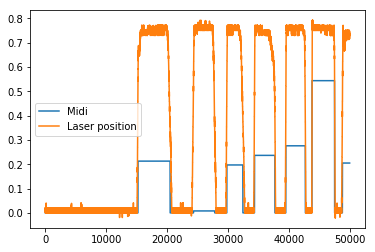

In [3]:
X, Y = load_data_lidar()
#X, Y = load_data_simulated()
#X, Y = load_data_continuous_discrete()
Laser, Midi = X[:100000], Y[:100000]
#plot_data(X[:50000], Y[:50000])

/usr/local/lib/python3.6/dist-packages/matplotlib/axes/_base.py:3215: MatplotlibDeprecationWarning: 
The `xmin` argument was deprecated in Matplotlib 3.0 and will be removed in 3.2. Use `left` instead.
  alternative='`left`', obj_type='argument')
/usr/local/lib/python3.6/dist-packages/matplotlib/axes/_base.py:3221: MatplotlibDeprecationWarning: 
The `xmax` argument was deprecated in Matplotlib 3.0 and will be removed in 3.2. Use `right` instead.
  alternative='`right`', obj_type='argument')


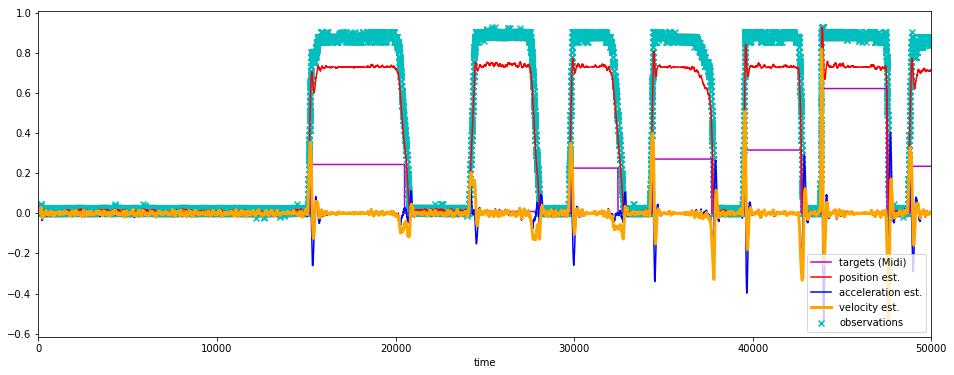

In [6]:
r'''
Example from https://pykalman.github.io/
@ernesto : added modifications to account for acceleration; changed transition 
           and noise models to acceleration-based, using Laser data for noise
           estimationip

'''
from pykalman import KalmanFilter

dt = 1 / SAMPLING_RATE
SENSOR_NOISE = np.std(Laser[2000:10000]) ** 2 
PROCESS_NOISE = 1000
G = np.array([[1/6 * dt**3, 1/2* dt**2, dt]]).T * PROCESS_NOISE
A = np.array([[1, dt, 0.5 * dt**2], 
              [0, 1, 1 * dt],
              [0, 0, 1]])
H = np.array([1, 0, 0])
Q = np.dot(G, G.T)

def load_dataset_kalman(observations, targets):
  # Uses Lidar observations data, estimates position, velocity, acceleration.
  # Outputs this three time series as features: shape = (timestamps, 3)
  kf = KalmanFilter(transition_matrices=A,
                    observation_matrices=H,                  
                    transition_covariance=Q,
                    observation_covariance=SENSOR_NOISE,
                    initial_state_mean = np.zeros(3),
                    initial_state_covariance = Q)
  #kf.em(observations) # re-estimate Kalman filter parameters (not needed)
  states_pred = kf.filter(observations)[0]
  #states_pred = kf.smooth(observations)[0]
  return observations, states_pred, targets

def load_dataset_kalman_online(observations, targets):
  # Uses Lidar observations data, estimates position, velocity, acceleration.
  # Outputs this three time series as features: shape = (timestamps, 3)
  kf = KalmanFilter(transition_matrices=A,
                    observation_matrices=H,                  
                    transition_covariance=Q,
                    observation_covariance=SENSOR_NOISE,
                    initial_state_mean = np.zeros(3),
                    initial_state_covariance = Q)
  n_observations, n_states = len(observations), len(A)
  means = np.zeros((n_observations, n_states))
  covs = np.zeros((n_observations, n_states, n_states))
  covs[0] = Q
  for t in range(1, len(observations)):
    data = observations[t]#[i * BLOCK : (i + 1) * BLOCK]
    means[t], covs[t] = kf.filter_update(means[t-1], covs[t-1], data)
  states_pred = means
  #states_pred = kf.filter(observations)[0]
  return observations, states_pred, targets


def load_dataset_kalman_block(observations, targets):
  # Uses Lidar observations data, estimates position, velocity, acceleration.
  # Outputs this three time series as features: shape = (timestamps, 3)
  kf = KalmanFilter(transition_matrices=A,
                    observation_matrices=H,                  
                    transition_covariance=Q,
                    observation_covariance=SENSOR_NOISE,
                    initial_state_mean = np.zeros(3),
                    initial_state_covariance = Q)
  n_observations, n_states = len(observations), len(A)
  means = np.zeros((n_observations, n_states))
  covs = np.zeros((n_observations, n_states, n_states))
  covs[0] = Q
  BLOCK = 500
  for t in range(1, len(observations), BLOCK):
    data = observations[t:t+BLOCK]
    kf.initial_state_mean = means[t-1]
    kf.initial_state_covatiance = covs[t-1]
    means[t:t+BLOCK], covs[t:t+BLOCK] = kf.filter(data)
  states_pred = means
  return observations, states_pred, targets


observations, states_pred, targets = load_dataset_kalman(
    Laser, Midi) 
  
  
# Plot lines for the observations without noise, the estimated position of the
# target before fitting, and the estimated position after fitting.
plt.figure(figsize=(16, 6))
#x = np.arange(len(targets))
N = 50000 # plot samples
x = np.arange(N)
obs_scatter =   plt.scatter(x, observations[:N] / observations.max(), marker='x', color='c',
                         label='observations')
targets_line   = plt.plot(x, targets[:N] / targets.max(), color='m',
                         label='targets (Midi)')
position_line = plt.plot(x, states_pred[:N, 0] / states_pred[:, 0].max(),
                        linestyle='-', color='r',
                        label='position est.')
acceler_line  = plt.plot(x, states_pred[:N, 2] / states_pred[:, 2].max(),
                        linestyle='-', color='b',
                        label='acceleration est.')
velocity_line = plt.plot(x, states_pred[:N, 1] / states_pred[:, 1].max(),
                        linestyle='-', color='orange', linewidth=3,
                        label='velocity est.')

plt.legend(loc='lower right')
plt.xlim(xmin=0, xmax=x.max())
plt.xlabel('time')
plt.show()

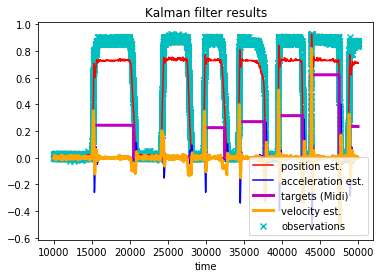

In [13]:
N,M=10000,50000
x = np.arange(N, M)
#plt.figure(figsize=(16, 6))
obs_scatter =   plt.scatter(x, observations[N:M] / observations.max(), marker='x', color='c',
                         label='observations', alpha = 1)
position_line = plt.plot(x, states_pred[N:M, 0] / states_pred[:, 0].max(),
                        linestyle='-', color='r',
                        label='position est.', alpha = 1)
acceler_line  = plt.plot(x, states_pred[N:M, 2] / states_pred[:, 2].max(),
                        linestyle='-', color='b',
                        label='acceleration est.', alpha = 1)
targets_line   = plt.plot(x, targets[N:M] / targets.max(), color='m',
                         label='targets (Midi)', linewidth=3)
velocity_line = plt.plot(x, states_pred[N:M, 1] / states_pred[:, 1].max(),
                        linestyle='-', color='orange', linewidth=3,
                        label='velocity est.')

plt.legend(loc='lower right')
#plt.xlim(xmin=0, xmax=x.max())
plt.xlabel('time')
plt.title("Kalman filter results")
plt.show()

In [0]:
Laser, Midi = states_pred, targets

In [8]:
TIMESTAMPS = SAMPLING_RATE
EXAMPLES = len(Laser) // TIMESTAMPS
FEATURES = 1 if Laser.ndim == 1 else Laser.shape[-1]
BATCH=4
NEURONS=64
LAYERS=1

Laser = Laser[:TIMESTAMPS * EXAMPLES].reshape((EXAMPLES, TIMESTAMPS, FEATURES))
Midi = Midi[:TIMESTAMPS * EXAMPLES].reshape((EXAMPLES, TIMESTAMPS, 1))

#X_train, X_test, Y_train, Y_test = train_test_split(Laser, Midi)
def time_split(X, Y, train_fraction=0.8):
  SPLIT_IDX = int(len(X) * train_fraction) 
  X_train, X_test, Y_train, Y_test = X[:SPLIT_IDX], X[SPLIT_IDX:], Y[:SPLIT_IDX], Y[SPLIT_IDX:]
  return X_train, X_test, Y_train, Y_test

X_train, X_test, Y_train, Y_test = time_split(Laser, Midi)
  
X_train, X_test, Y_train, Y_test = (
    X_train[:len(X_train) // BATCH * BATCH], X_test[:len(X_test) // BATCH * BATCH], 
    Y_train[:len(X_train) // BATCH * BATCH], Y_test[:len(X_test) // BATCH * BATCH])

model = create_model(batch_len=BATCH, input_len=Laser.shape[1], hidden_neurons=NEURONS, hidden_layers=1, features=FEATURES)
print(Midi.shape, Laser.shape)
print(X_train.shape, Y_train.shape, X_test.shape, Y_test.shape)

Instructions for updating:
Colocations handled automatically by placer.
(50, 2000, 1) (50, 2000, 3)
(40, 2000, 3) (40, 2000, 1) (8, 2000, 3) (8, 2000, 1)


In [9]:
def transform_to_multiple_outputs(Y):
  return [Y, np.asarray(Y > 0, dtype=np.int)]

model.fit(X_train, transform_to_multiple_outputs(Y_train), epochs=200, batch_size=BATCH, verbose=True, 
          validation_data=(X_test, transform_to_multiple_outputs(Y_test)))

Instructions for updating:
Use tf.cast instead.
Train on 40 samples, validate on 8 samples
Epoch 1/200
40/40 [==============================] - 6s 162ms/step - loss: 0.7823 - lambda_1_loss: 0.1021 - dense_2_loss: 0.6802 - val_loss: 0.8566 - val_lambda_1_loss: 0.2385 - val_dense_2_loss: 0.6182
Epoch 2/200
40/40 [==============================] - 5s 135ms/step - loss: 0.6640 - lambda_1_loss: 0.0586 - dense_2_loss: 0.6053 - val_loss: 0.6264 - val_lambda_1_loss: 0.1099 - val_dense_2_loss: 0.5164
Epoch 3/200
40/40 [==============================] - 5s 137ms/step - loss: 0.4929 - lambda_1_loss: 0.0494 - dense_2_loss: 0.4435 - val_loss: 0.4926 - val_lambda_1_loss: 0.1090 - val_dense_2_loss: 0.3836
Epoch 4/200
40/40 [==============================] - 5s 136ms/step - loss: 0.3667 - lambda_1_loss: 0.0520 - dense_2_loss: 0.3147 - val_loss: 0.4907 - val_lambda_1_loss: 0.1424 - val_dense_2_loss: 0.3483
Epoch 5/200
40/40 [==============================] - 5s 137ms/step - loss: 0.3030 - lambda_1_loss

In [10]:
from sklearn.metrics import mean_squared_error
Y_train_pred, Y_train_pred_toggle = model.predict(X_train, batch_size=BATCH)
Y_test_pred, Y_test_pred_toggle = model.predict(X_test, batch_size=BATCH)
print("MSE Train:", mean_squared_error(Y_train.flatten(), Y_train_pred.flatten()))
print("MSE Test:", mean_squared_error(Y_test.flatten(), Y_test_pred.flatten()))
print("MSE Random (Mean prediction):", mean_squared_error(Y_test.flatten(), np.mean(Y_train) + np.zeros_like(Y_test).flatten()))

MSE Train: 0.027004455920740043
MSE Test: 0.08142087336727356
MSE Random (Mean prediction): 0.19971132939499506


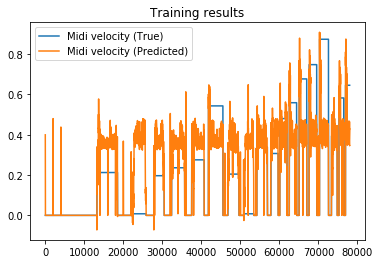

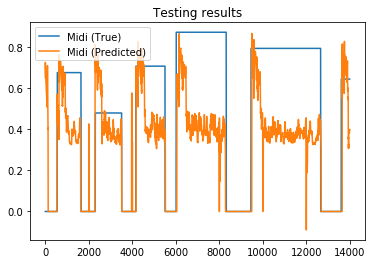

In [11]:
M, N = 1, 500
plt.title("Training results")
#plt.plot(X_train[M:N].flatten(), label="Laser")
plt.plot(Y_train[M:N].flatten(), label="Midi velocity (True)")
plt.plot(Y_train_pred[M:N].flatten(), label="Midi velocity (Predicted)")
#plt.plot(Y_train_pred_toggle[M:N].flatten(), label="Toggle (predicted)")
plt.legend()

plt.figure()
plt.title("Testing results")
#plt.plot(X_test[M:N].flatten(), label="Laser")
plt.plot(Y_test[M:N].flatten(), label="Midi (True)")
plt.plot(Y_test_pred[M:N].flatten(), label="Midi (Predicted)")
#plt.plot(Y_test_pred_toggle[M:N].flatten(), label="Toggle (predicted)")
plt.legend()

/usr/local/lib/python3.6/dist-packages/sklearn/neural_network/multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


0.06790070632211004
0.04124825194094832


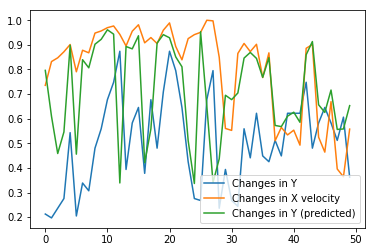

In [0]:
# TRYING TO UNDERSTAND RELATIONSHIP   Velocity -> MIDI

change_idx = targets - np.roll(targets, 1) > 0.05
X_changes = states_pred[change_idx.flatten()]
Y_changes = targets[change_idx]

N = 50
plt.plot(Y_changes[:N], label="Changes in Y")
#plt.plot(X_changes[:N, 0], label="Changes in X position")
plt.plot(X_changes[:N, 1] / X_changes[:, 1].max(), label="Changes in X velocity")

from sklearn.neural_network import MLPRegressor
model = MLPRegressor(hidden_layer_sizes=10)

model.fit(X_changes, Y_changes)
Y_changes_pred = model.predict(X_changes)

plt.plot(Y_changes_pred[:N], label="Changes in Y (predicted)")
plt.legend()

from sklearn.metrics import mean_squared_error
print(mean_squared_error(Y_changes_pred, Y_changes))
print(mean_squared_error(np.full_like(Y_changes, Y_changes.mean()), Y_changes))

In [0]:
##### LIDAR EXAMPLE ########


import math

def print_response_data(data):
    for frame in range(0, len(data), 8):
        s = ''
        for b in data[frame:frame+8]:
            s += '{:02x} '.format(b)
        print('{:02x}: {}'.format(frame, s))

# Commands that can be sent to RPLIDARs.
class Command:
    Stop = 0x25
    Reset = 0x40
    Scan = 0x20
    ExpressScan = 0x82
    ForceScan = 0x21
    GetInfo = 0x50
    GetHealth = 0x52
    GetSampleRate = 0x59

# data types returned in data response descriptors
class ResponseType:
    ScanData = 0x81
    ExpressScanData = 0x82
    DeviceInfo = 0x04
    HealthInfo = 0x06
    SamplingRate = 0x15

# two-bit send modes returned in data response descriptors
class SendMode:
    SingleResponse = 0x00
    MultipleResponse = 0x01


class RPLidar:
    """
    Controls and reads data from an RPLIDAR laser rangefinder.

    Args:
        serial_type (str): Serial port API to use. Must be one of either
            ``pyserial`` or ``wpilib``.
        port (str): Serial port to use. If using ``pyserial``, this should be
            a serial port device name (i.e. ``/dev/ttyS1`` or ``COM0``).
            If using ``wpilib``, this should be one of
            :obj:`wpilib.SerialPort.Port`.
        read_timeout (float, optional): Maximum number of seconds to spend
            waiting for data from the RPLIDAR.
    """

    __exp_packet_buf = None  # buffered Express Scan packet.

    def __init__(
        self,
        serial_type='pyserial',
        port='/dev/ttyS1',
        read_timeout=0.010  # seconds to wait for I/O
    ):
        self.type = serial_type

        # pyserial.Serial and wpilib.SerialPort have identical signatures
        # for read() and write(). That's all we need.
        if serial_type == 'pyserial':
            import serial
            import time

            self.dev = serial.Serial(port, 115200, timeout=read_timeout)

            self.sleep = time.sleep
            self.reset_input_buffer = self.dev.reset_input_buffer
        elif serial_type == 'wpilib':
            import wpilib

            self.dev = wpilib.SerialPort(115200, port)
            self.dev.setWriteBufferMode(wpilib.SerialPort.WriteBufferMode.kFlushOnAccess)  # noqa: E501
            self.dev.setReadBufferSize(40000)
            self.dev.setTimeout(read_timeout)

            self.sleep = wpilib.Timer.delay
            self.reset_input_buffer = self.dev.reset

    def _bytes_available(self):
        if self.type == 'pyserial':
            return self.dev.in_waiting
        elif self.type == 'wpilib':
            return self.dev.getBytesReceived()

    def _read_response_descriptor(self):
        while True:
            checked_byte = self.dev.read(1)
            #print("Read {}...".format(checked_byte))
            if checked_byte == b'\xA5':
                break

        raw_desc = bytearray(b'\xA5')
        raw_desc.extend(self.dev.read(6))

        if len(raw_desc) < 6:
            raise IOError("RPLIDAR timed out while waiting for command response")  # noqa: E501

        if raw_desc[1] != 0x5A:
            raise IOError('RPLIDAR communication error (response descriptor header not found)')  # noqa: E501

        t = (
            raw_desc[2]
            | (raw_desc[3] << 8)
            | (raw_desc[4] << 16)
            | (raw_desc[5] << 24)
        )

        data_type = raw_desc[6]

        response_length = t & ~(3 << 30)
        send_mode = (t & (3 << 30)) >> 30

        print("Got response descriptor...")
        print("Len: {}, Mode: {}, Data Type: {:x}".format(
            response_length, send_mode, data_type
        ))

        return response_length, send_mode, data_type

    def _wait_response_descriptor(self, dtype):
        while True:
            dlen, mode, resp_dtype = self._read_response_descriptor()
            if dtype == resp_dtype:
                return dlen, mode, resp_dtype

    def stop_scan(self):
        """
        Command the RPLIDAR to stop scanning.
        """
        self.dev.write(bytes([0xA5, 0x25]))
        self.sleep(0.001)

    def reset(self):
        """
        Command the RPLIDAR to reboot itself.
        """

        self.dev.write(bytes([0xA5, 0x40]))
        self.sleep(0.002)

    def start_scan(self):
        """
        Command the RPLIDAR to begin standard scanning.

        To retrieve scan measurements, call :method:`poll_scan_samples`.

        Note:
            The RPLIDAR will only begin to return samples after the sensor's
            motor rotation has stabilized.
        """

        self.dev.write([0xA5, 0x20])
        self._wait_response_descriptor(ResponseType.ScanData)

    def poll_scan_samples(self):
        """
        Read all available scan samples from the RPLIDAR.

        Returns:
            A (possibly empty) list of (angle, distance, scan_start) tuples:

            - Angles are returned in units of degrees.
            - Distances are returned in units of millimeters.
            - ``scan_start`` will be True if the sample and all successive
              samples belong to a new 360-degree scan.
        """

        samples_available = math.floor(self._bytes_available() / 5)
        if samples_available <= 0:
            return []

        data = bytearray(self.dev.read(samples_available * 5))
        samples = []  # list of (angle, distance, scan_start) tuples

        for i in range(samples_available):
            packet = data[i*5 : (i+1)*5]

            # True if incoming packets are part of new scan
            scan_start = bool(packet[0] & 1)
            inv_scan_start = bool(packet[0] & 2)  # inverse of scan_start
            check_bit = bool(packet[1] & 1)  # should always be True

            # data check
            if (scan_start == inv_scan_start) or not check_bit:
                continue  # invalid packet

            # (logical) right shift for low bits, combine with high bits
            # Angles are returned as Q6 fixed-point numbers; divide everything
            # by 64.0 to account for this.
            angle_q6 = float(
                ((packet[1] >> 1) & 0x7F)
                | (packet[2] << 7)
            ) / 64.0

            distance_q2 = float(packet[3] | (packet[4] << 8)) / 4

            samples.append((angle_q6, distance_q2, scan_start))

        return samples

    def start_express_scan(self):
        """
        Command the RPLIDAR to begin express scanning.

        Express scanning uses a higher sampling rate than standard scanning,
        but uses a different and more processing-intensive format
        for transmitting data samples.

        To retrieve scan measurements, call
        :method:`poll_express_scan_samples`.
        """

        # Yes, the payload is 5 zero bytes. This is demanded by the spec.
        self.dev.write([0xA5, 0x82, 0x05, 0, 0, 0, 0, 0, 0x22])
        self._wait_response_descriptor(ResponseType.ExpressScanData)

    def poll_express_scan_samples(self):
        """
        Read all available express scan samples from the RPLIDAR.

        The format used by express scan packets represents angles in
        a compressed format. Unfortunately, the way this compression is
        done requires that packets be processed sequentially; in order to
        process packet *i*, packet *i+1* must first be read.

        Returns:
            A (possibly empty) list of (angle, distance, scan_start) tuples.
            The semantics of these quantities are the same as
            :method:`poll_scan_results`.
        """

        packets_available = math.floor(self._bytes_available() / 84)
        if packets_available <= 0:
            return []

        data = bytearray(self.dev.read(packets_available * 84))
        samples = []

        for i in range(packets_available):
            p_next = data[i*84 : (i+1)*84]  # packet

            sync1 = (p_next[0] >> 4) & 0xF
            sync2 = (p_next[1] >> 4) & 0xF

            # Received checksum
            chksum_rcv = (p_next[0] & 0xF) | ((p_next[1] & 0xF) << 4)

            # Computed checksum; XOR over all packet data bytes
            chksum_cmp = 0
            for i in range(2, 84):
                chksum_cmp ^= p_next[i]

            if sync1 != 0xA or sync2 != 0x5 or chksum_cmp != chksum_rcv:
                # This packet is invalid.
                # Neither this packet, nor the previous packet, can be
                # processed.
                self.__exp_packet_buf = None
                continue

            p = self.__exp_packet_buf
            self.__exp_packet_buf = p_next

            if p is None:
                # Wait for a packet that we can process
                continue

            # Angles are represented as Q6 fixed-point numbers, in degrees
            cur_angle = float(p[2] | ((p[3] & 0x7F) << 8)) / 64.0
            next_angle = float(p_next[2] | ((p_next[3] & 0x7F) << 8)) / 64.0

            angle_diff = next_angle - cur_angle
            if angle_diff < 0:
                angle_diff += 360

            scan_start = bool(p[3] & 0x80)

            # Each express scan packet contains 16 5-byte "cabin"
            # substructures, each of which contains 2 samples.
            for cabin_idx in range(16):
                c = p[4+(cabin_idx*5) : 9+(cabin_idx*5)]  # cabin data

                dist_1 = ((c[0] >> 1) & 0x7F) | (c[1] << 7)
                dist_2 = ((c[2] >> 1) & 0x7F) | (c[3] << 7)

                angle_comp_1 = float(c[4] & 0xF) / 8.0
                angle_comp_2 = float((c[4] >> 4) & 0xF) / 8.0

                # check sign bits
                if c[0] & 1:
                    angle_comp_1 *= -1

                if c[2] & 1:
                    angle_comp_2 *= -1

                angle_1 = cur_angle + (angle_diff / 32 * k) - angle_comp_1
                angle_2 = cur_angle + (angle_diff / 32 * k) - angle_comp_2

                if dist_1 != 0:
                    samples.append((angle_1, float(dist_1), scan_start))

                    # ensure only 1 sample in a scan has scan_start = True
                    scan_start = False

                if dist_2 != 0:
                    samples.append((angle_2, float(dist_2), scan_start))
                    scan_start = False

        return samples

    def force_start_scan(self):
        """
        Command the RPLIDAR to begin normal scanning and immediately return
        measurement samples.

        This method puts the RPLIDAR into the same scanning mode as
        :method:`start_scan`, but further commands the RPLIDAR to immediately
        begin returning measurement samples; in other words, the RPLIDAR will
        not wait for sensor rotation to stabilize before returning data.
        """

        self.dev.write([0xA5, 0x21])
        self._wait_response_descriptor(ResponseType.ScanData)

    def get_device_info(self):
        """
        Retrieve hardware information from the RPLIDAR.

        Returns:
            A tuple containing:

            - The RPLIDAR model ID, as an integer
            - The firmware version number, as a ``float``
            - The hardware version number, as an integer
            - The 128-bit serial number, as ``bytes``.
        """
        print("Sent Device Info command...")
        self.dev.write(bytes([0xA5, 0x50]))
        self._wait_response_descriptor(ResponseType.DeviceInfo)

        data = bytearray(self.dev.read(20))

        print("Device Info:")
        print_response_data(data)

        if len(data) < 20:
            raise IOError("RPLIDAR timed out while waiting for device info")

        model = data[0]
        fw = float(data[1] | (data[2] << 8)) / 256.0
        hw = data[3]
        serial_no = bytes(data[4:])

        return (model, fw, hw, serial_no)

    def get_device_health(self):
        """
        Retrieve the health status of the RPLIDAR.

        Returns:
            A tuple containing:

            - The RPLIDAR's status

                - 0 indicates a healthy device.
                - 1 indicates a warning status: the device works, but may fail
                  soon.
                - 2 indicates an error status.

            - An error code
        """

        self.dev.write(bytes([0xA5, 0x52]))
        self._wait_response_descriptor(ResponseType.HealthInfo)

        data = bytearray(self.dev.read(3))

        print("Device Health Info:")
        print_response_data(data)

        if len(data) < 3:
            raise IOError("RPLIDAR timed out while waiting for health info")

        error_code = data[1] | (data[2] << 8)

        return data[0], error_code

    def get_sample_period(self):
        """
        Get the time taken by the RPLIDAR between measurements.

        Returns:
            A tuple containing:

            - The time between standard sample measurements, in microseconds.
            - The time between express sample measurements, in microseconds.
        """

        self.dev.write([0xA5, 0x59])
        self._wait_response_descriptor(ResponseType.SampleRate)

        data = bytearray(self.dev.read(4))

        if len(data) < 20:
            raise IOError("RPLIDAR timed out while waiting for sampling period")  # noqa: E501

        t_standard = data[0] | (data[1] << 8)
        t_express = data[2] | (data[3] << 8)

        return t_standard, t_express

    def acc_board_set_pwm(self, pwm_level=660):
        """
        Set the PWM output via the Accessory Board.

        Args:
            pwm_level (integer): An integer from 0-1023 setting the RPLIDAR's
                motor power.
        """

        payload1 = pwm_level & 0xFF
        payload2 = (pwm_level >> 8) & 0xFF

        cmd_string = [0xA5, 0xF0, 2, payload1, payload2]
        checksum = 0
        for b in cmd_string:
            checksum ^= b
        cmd_string.append(checksum)

        print_response_data(cmd_string)

        self.dev.write(bytes(cmd_string))
        self.sleep(0.020)




#######




import csv
import time
import math
import sys
from collections import deque
import numpy as np
#from rplidar import RPLidar
import pygame



MAX_LEN = 4000
#samples = deque([0]*MAX_LEN, MAX_LEN)
#samples_midi = deque([0]*MAX_LEN, MAX_LEN)
#samples = []
#samples_midi = []


#def exit():
#    lidar.stop_scan()
#    lidar.dev.dtr = True
#    sys.exit(0)

#print("Setting board PWM...")
#lidar.dev.dtr = not False         ## STOP MOTOR


import matplotlib.animation as animation
import matplotlib.pyplot as plt

class Sensor:
    def __init__(self):
        self.min = 0
        self.max = 1
        self.sigma = 0
        self.samples = np.array([])
        self.buffer = []
        self.is_calibrated = False
    
    def calibrate_noise(self, start, end):
        self.sigma= np.std(self.samples[start:end])
        print("Noise:", self.sigma)

    def calibrate_values(self, start, end, reset=True):
        self.min = 0.999 * np.quantile(self.samples[start:end], 0.01)
        self.max = 1.001 * np.quantile(self.samples[start:end], 0.99)
        self.is_calibrated = True
        self.samples = self.scale(self.samples)
        print("Range:", self.min, self.max)

    def reset(self):
        self.samples = np.array([])        
        
    def scale(self, data):
        if self.is_calibrated:
            data_scaled = (np.asarray(data) - self.min ) / (self.max - self.min)
            return data_scaled # np.clip(data_scaled, 0, 1)
        else:
            return data
        
    def read_samples(self, ):
        self.buffer = []
    
    def save_samples(self, needed_samples):
        if self.buffer:
            current_samples = len(self.buffer)
            new_data = np.interp(
                    np.linspace(0, 1, needed_samples),
                    np.linspace(0, 1, current_samples),
                    self.scale(self.buffer))
        else:
            last_value = 0 if len(self.samples) == 0 else self.samples[-1]
            new_data = np.full(needed_samples, last_value)
        self.samples = np.concatenate((self.samples, new_data))
        self.buffer = []

import mido

class MidiSensor(Sensor):
    def __init__(self):
        Sensor.__init__()
        device_names = mido.get_input_names()
        if device_names:
            self.device = mido.open_input(mido.get_input_names()[0])
        else:
            self.device = None
            
    def read_samples(self):
        self.buffer = []
        for msg in self.device.iter_pending():
            self.buffer.append(msg.velocity)
        
class LidarSensor(Sensor):
    def __init__(self):
        Sensor.__init__(self)
        serial_port = '/dev/ttyUSB3'
        lidar = RPLidar(port=serial_port)
        print("Sent RESET command...")
        lidar.reset()
        time.sleep(1)
        model, fw, hw, serial_no = lidar.get_device_info()
        health_status, err_code = lidar.get_device_health()   
        print(
            '''
            ===
        
            Opened LIDAR on serial port {}
            Model ID: {}
            Firmware: {}
            Hardware: {}
            Serial Number: {}
            Device Health Status: {} (Error Code: 0x{:X})
        
            ===
            '''.format(
                serial_port, model, fw, hw, serial_no.hex(),
                health_status, err_code
            )
        ) 
        lidar.force_start_scan()
        self.lidar = lidar
        
    def read_samples(self):
        samples = self.lidar.poll_scan_samples()
        self.buffer = [sample[1] for sample in samples] # distances
        #print("[{}] Read {} samples... Mean: {}".format(
        #    time.time(), len(self.buffer), np.mean(self.buffer)))
        
    
class AccelerometerSensor(Sensor):
    pass


from pykalman import KalmanFilter

class Filter:
    def __init__(self, sigma=0, fs=2000):
        dt = 1 / fs
        PROCESS_NOISE = 1
        SENSOR_NOISE = sigma ** 2 
        G = np.array([[1/6 * dt**3, 1/2* dt**2, dt]]).T * PROCESS_NOISE
    
        self.kf = KalmanFilter(
                transition_matrices=np.array([[1, dt, 0.5 * dt**2], 
                                              [0, 1, 1 * dt],
                                              [0, 0, 1]]),
                observation_matrices=np.array([1, 0, 0]),                  
                transition_covariance=np.dot(G, G.T),
                observation_covariance=SENSOR_NOISE,
                initial_state_mean = np.zeros(3),
                initial_state_covariance = G)
        self.state_mean = self.kf.initial_state_mean
        self.state_cov = self.kf.initial_state_covariance

    def update(self, observations):
        print("Update:", self.state_mean.shape)
        for observation in observations:
            self.state_mean, self.state_cov = self.kf.filter_update(self.state_mean, self.state_cov, observation)
        #self.kf.initial_state_mean = self.state_mean
        #self.kf.initial_state_covarianc = self.state_cov
        #pred_mean, pred_cov = self.kf.filter(observations)
        #self.state_mean = pred_mean[-1, :]
        #self.state_cov = pred_cov[-1, :]
        #return pred_mean, pred_cov
        print("Update:", self.state_mean.shape)
        return self.state_mean, self.state_cov
    



class Processor:
    def __init__(self, sensors, fs=2000):
        self.sensors = sensors
        self.fs = fs
        self.stored_samples = 0
        self.WAITING = 0
        self.CALIBRATE_NOISE = 2 * self.fs
        self.CALIBRATE_START = 5 * self.fs
        self.CALIBRATE_END = 10 * self.fs
        self.state = self.WAITING
        self.start_time = time.time()
        self.playing = 0
        self.out_port = mido.open_output(mido.get_output_names()[0])
        self.filter = None # will be initialized after calibration
        self.kalman_means = None
        self.kalman_covs = None
        
    def sensor_fusion(self, needed_samples):
        #print("Fusion:", needed_samples)
        means, covs = self.filter.update(
                self.sensors[0].samples[-needed_samples:])
        if self.kalman_means is None:
            self.kalman_means = means
        else:
            self.kalman_means = np.concatenate(
                    (self.kalman_means, means), axis=0)
    # UPDATED       
    def trigger(self, needed_samples):
        position = self.kalman_means[-1]#sensors[0].samples[-1]
        if self.playing == 0 and position < 0.45:
            self.playing = 1
            self.out_port.send(mido.Message(
                    'note_on', note=60, velocity=60))
        elif self.playing == 1 and position > 0.55:
            self.playing = 0
            self.out_port.send(mido.Message(
                    'note_off', note=60))
    
    def state_machine(self, needed_samples):
        if self.state == self.WAITING:
            if self.stored_samples > self.CALIBRATE_NOISE:
                print("Noise calibration...")
                self.state = self.CALIBRATE_NOISE
        elif self.state == self.CALIBRATE_NOISE:
            if self.stored_samples > self.CALIBRATE_START:
                for sensor in self.sensors:
                    sensor.calibrate_noise(
                            self.CALIBRATE_NOISE, self.CALIBRATE_START)
                print("Position calibration...")
                self.state = self.CALIBRATE_START
        elif self.state == self.CALIBRATE_START:
            if self.stored_samples > self.CALIBRATE_END:
                for sensor in self.sensors:
                    sensor.calibrate_values(
                            self.CALIBRATE_START, self.CALIBRATE_END)
                    sensor.calibrate_noise(
                            self.CALIBRATE_NOISE, self.CALIBRATE_START)
                # starting over after reset
                self.reset()
                self.filter = Filter(
                        self.sensors[0].sigma, self.fs)                    
                print("Calibration done!")
                self.state = self.CALIBRATE_END
        else:
            # normal operation
            self.sensor_fusion(needed_samples)
            self.trigger(needed_samples)
            pass

    def reset(self):
        for sensor in self.sensors:
            sensor.reset()
        self.stored_samples = 0
        self.start_time = time.time()
        
    def process(self):
        for sensor in self.sensors:
            sensor.read_samples()
        elapsed = time.time() - self.start_time
        expected_samples = int(np.round(elapsed * self.fs))
        needed_samples = expected_samples - self.stored_samples
        for sensor in self.sensors:
            sensor.save_samples(needed_samples)        
        self.stored_samples += needed_samples
        self.state_machine(needed_samples)


class Grapher:
    def __init__(self, processor, max_len):
        self.processor = processor
        self.max_len = max_len
        self.fig, self.ax = plt.subplots()
        self.ax.set_ylim(0, 1)
        self.lines = [self.ax.plot(np.zeros(max_len))[0] 
                      for i in range(len(processor.sensors))]

    def update(self):
        for sensor, line in zip(processor.sensors, self.lines):
            #samples = sensor.samples[-self.max_len:]
            if processor.kalman_means:
                samples = processor.kalman_means[-self.max_len:, 0]
                if len(samples) < self.max_len:
                    samples = np.pad(samples, self.max_len - len(samples), 
                                     mode='constant')
                # print(np.mean(samples))
                line.set_ydata(samples)
    
    def animate(self, frame):
        processor.process()        
        self.update()
        return self.lines

    def get_animation(self):
        ani = animation.FuncAnimation(self.fig, self.animate,
                                      interval=1, blit=True)
        self.fig.show()
        return ani
            
sensors = [LidarSensor(),]
processor = Processor(sensors)
grapher = Grapher(processor, max_len=4000)   

ani = grapher.get_animation()






'''
from os import path
TRIM = 2000

def save_data():
    folder = path.expanduser("~/Projects/Sound/AIPiano/data/lidar/")
    np.save(folder + "samples_laser2", samples[TRIM:])
    np.save(folder +"samples_midi2", samples_midi[TRIM:])

def plot_data():
   plt.plot(samples[TRIM:])
   plt.plot(samples_midi[TRIM:])
plot_data()

save_data()
'''

out_port = mido.open_output(mido.get_output_names()[0])